In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

from utils import get_model_metrics, has_keyword


Ссылка на репо с парсером, откуда был получен данный [dataset](https://github.com/itmo-ml-lab-ML-course/parser-Dforgeek)


In [2]:
df = pd.read_csv('hotel_data.csv')

df.head()

,Hotel Name,Is Top Stays,Center Distance,Metro Distance,Price,Rating,Number of Reviews,Description,Индивидуальная регистрация заезда и отъезда,Компьютер,...,Упакованные ланчи,Бесплатный Wi-Fi,Доступ в интернет,Трансфер,Трансфер от аэропорта,Персонал говорит на английском,Персонал говорит на русском,Парковка,Размещение подходит для семей/детей,Размещение с домашними животными не допускается
0,Апартаменты Премиум на Стрелке Васильевского,True,1.4,0.605,6800.0,9.9,12.0,"Выбор туристов, которые хотят везде чувствоват...",True,False,...,False,True,False,False,False,False,False,True,True,False
1,Апартаменты Антресоль,True,1.7,0.415,2300.0,9.3,89.0,Подходящий вариант для большой компании: апарт...,False,False,...,False,False,True,False,False,False,False,True,False,True
2,Апартаменты 15 комнат Петербургская квартира,True,2.5,0.281,1800.0,8.4,41.0,Залог хорошего отдыха — чувствовать себя в нов...,False,False,...,False,False,True,False,False,False,False,False,True,False
3,Апартаменты Art Mayak,True,2.2,0.797,10400.0,10.0,7.0,Апартаменты «Art Mayak» расположены в Санкт-Пе...,True,False,...,False,True,False,False,False,False,False,True,True,True
4,Отель ARTSTUDIO Nevsky,True,2.9,0.355,5600.0,8.5,187.0,Отель бизнес-класса «ARTSTUDIO Nevsky» располо...,True,False,...,False,True,False,True,True,False,False,True,True,False


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12619 entries, 0 to 12618
Data columns (total 51 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Hotel Name                                       12619 non-null  object 
 1   Is Top Stays                                     12619 non-null  bool   
 2   Center Distance                                  12619 non-null  float64
 3   Metro Distance                                   12619 non-null  float64
 4   Price                                            12604 non-null  float64
 5   Rating                                           6498 non-null   float64
 6   Number of Reviews                                6313 non-null   float64
 7   Description                                      12517 non-null  object 
 8   Индивидуальная регистрация заезда и отъезда      12619 non-null  bool   
 9   Компьютер                   

In [4]:
df.describe()

,Center Distance,Metro Distance,Price,Rating,Number of Reviews
count,12619.000000,12619.000000,12604.000000,6498.000000,6313.000000
mean,4.582787,0.768169,4469.533481,8.452847,19.718834
std,3.880746,0.690413,3267.330770,1.497919,40.612855
min,0.000000,0.030000,900.000000,1.000000,1.000000
25%,2.000000,0.338000,3000.000000,7.800000,2.000000
50%,2.900000,0.579000,3800.000000,8.800000,6.000000
75%,6.800000,0.981000,5000.000000,9.600000,18.000000
max,24.500000,4.900000,116800.000000,10.000000,780.000000


Заменим пробелы в названиях на нижние подчёркивания, на случай если будут обращения к столбцам не через ['...']. Заменим так же булевы столбцы на столбцы со значениями 1/0, так как не все модели правильно воспринимиают булевы значения. Также заменим null значения в rating и number_of_reviews на ноль, так как null там обозначает именно отсутствие отзывов и рейтинга, потому что отели непопулярные. 

In [5]:
df.columns = df.columns.str.replace(' ', '_')
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)
df = df.dropna(subset=['Price'])
df = df.fillna(0)


Построим некоторый baseline, который будем пытаться постоянно улучшать - попробуем просто предсказать среднее и посмотрим, какие метрики мы получаем. Очевидно, что мы хотим получить что-то лучше просто среднего

In [6]:
from sklearn.dummy import DummyRegressor

X, y = df.drop(['Hotel_Name', 'Price', 'Description'], axis=1), df['Price']
dummy = DummyRegressor(strategy='mean')
metrics = get_model_metrics(X, y, dummy)

Train:
MAE: 1565.2077462506008
MAPE: 0.3772353530060476
MSE: 9435127.489737589
Test:
MAE: 1670.3589874804688
MAPE: 0.3886253762603607
MSE: 15633315.481597163


Ого! Хреновый результат!

In [7]:
regr = DecisionTreeRegressor()
metrics = get_model_metrics(X, y, regr)


Train:
MAE: 13.793688486193524
MAPE: 0.003265132947982518
MSE: 16828.624305060453
Test:
MAE: 1917.8566706333463
MAPE: 0.43138644228031003
MSE: 20361435.161250845


Можем видеть явное переобучение модели. Будем пробовать улучшить результат

Посмотрим на распределение таргета (цены)

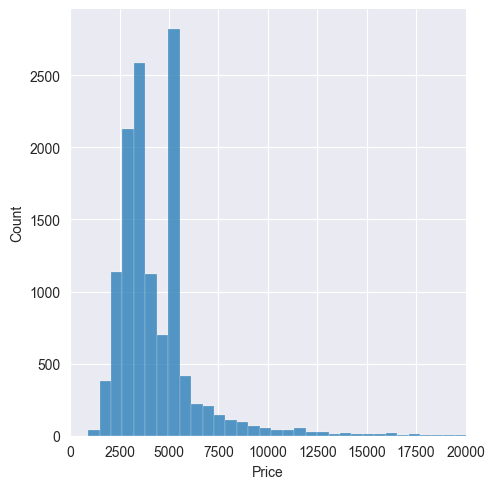

In [8]:
sns.displot(df['Price'], bins=200)
plt.xlim(0, 20000)
plt.show()

<Axes: xlabel='Price'>

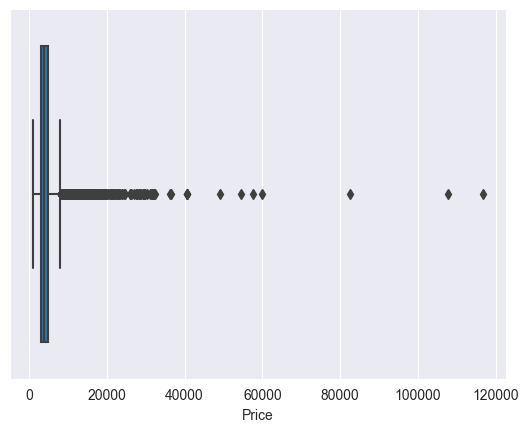

In [9]:
sns.boxplot(data=df, x='Price')

Можем видеть сильнейшие выбросы, которые ну никак не попадают в интерквартальный размах всех остальных данных

In [10]:
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Price'] < lower_bound) | (df['Price'] > upper_bound)]
percentage_outliers = (len(outliers) / len(df)) * 100

lower_bound, upper_bound, len(outliers), percentage_outliers

(0.0, 8000.0, 677, 5.3713106950174545)

Можно считать выбросами все отели, которые стоят дороже 8000, потому что примеров с такими ценами очень мало, и это скорее будет мешать учиться нашей модели, чем помогать. Значение это я получил исходя из метода интерквартального размаха (IQR)

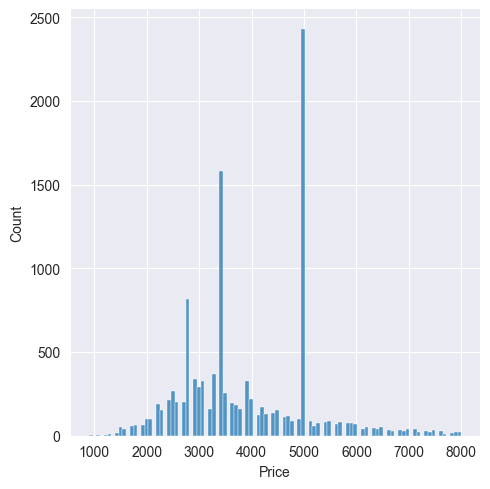

In [11]:
df = df[df['Price'] <= upper_bound]
sns.displot(df['Price'], bins=100)
plt.show()

<Axes: >

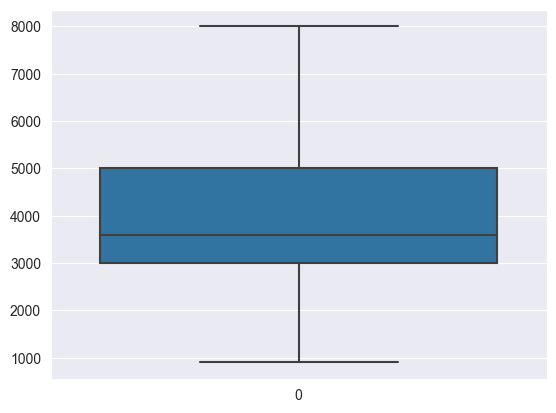

In [12]:
sns.boxplot(df['Price'])


Стоит объяснить один момент - можно видеть, что конкретные цены прям "стреляют" вверх на нашем распределении. Объясняется это тем, что при парсинге я сидел с vpn, и все цены были в евро, причём как правило евро было целым числом. Видимо применяется какое-то округление на самом сайте. Поэтому при переводе в рубли так вышло, что конкретные ценовые значения очень часто совпадают, но по сути там есть некоторая эпсилон-окрестность, в которой эта цена находится.

In [13]:
X, y = df.drop(['Hotel_Name', 'Price', 'Description'], axis=1), df['Price']
regr = DecisionTreeRegressor()
metrics = get_model_metrics(X, y, regr)

Train:
MAE: 10.982734986878096
MAPE: 0.0029176405416027154
MSE: 10236.954649798292
Test:
MAE: 1181.1555971927746
MAPE: 0.3259557837578289
MSE: 2477134.4464844107


<Axes: >

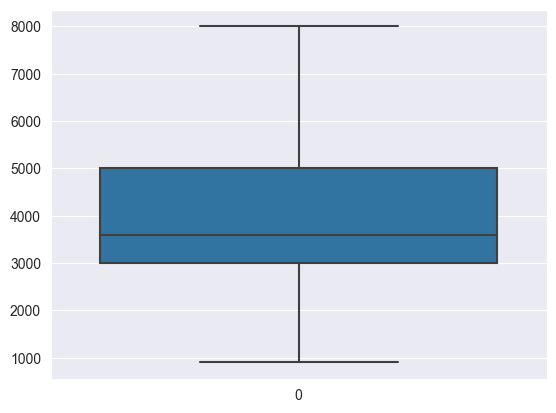

In [14]:
sns.boxplot(df['Price'])


Можно видеть явное улучшение по метрикам

<Axes: xlabel='Is_Top_Stays', ylabel='Rating'>

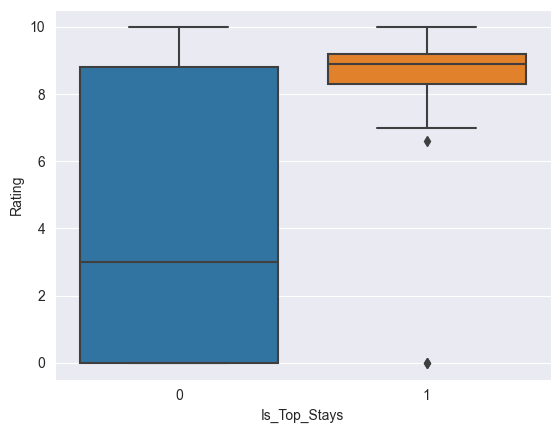

In [15]:
sns.boxplot(data=df, x='Is_Top_Stays', y='Rating')


Исходя из нашего ящика с усами можно понять, что пометку Top Stays получают только отели с хорошим рейтингом.

Построим матрицу корреляций

C:\Users\Dforgeek\AppData\Local\Temp\ipykernel_18800\1291641432.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, linecolor='black')


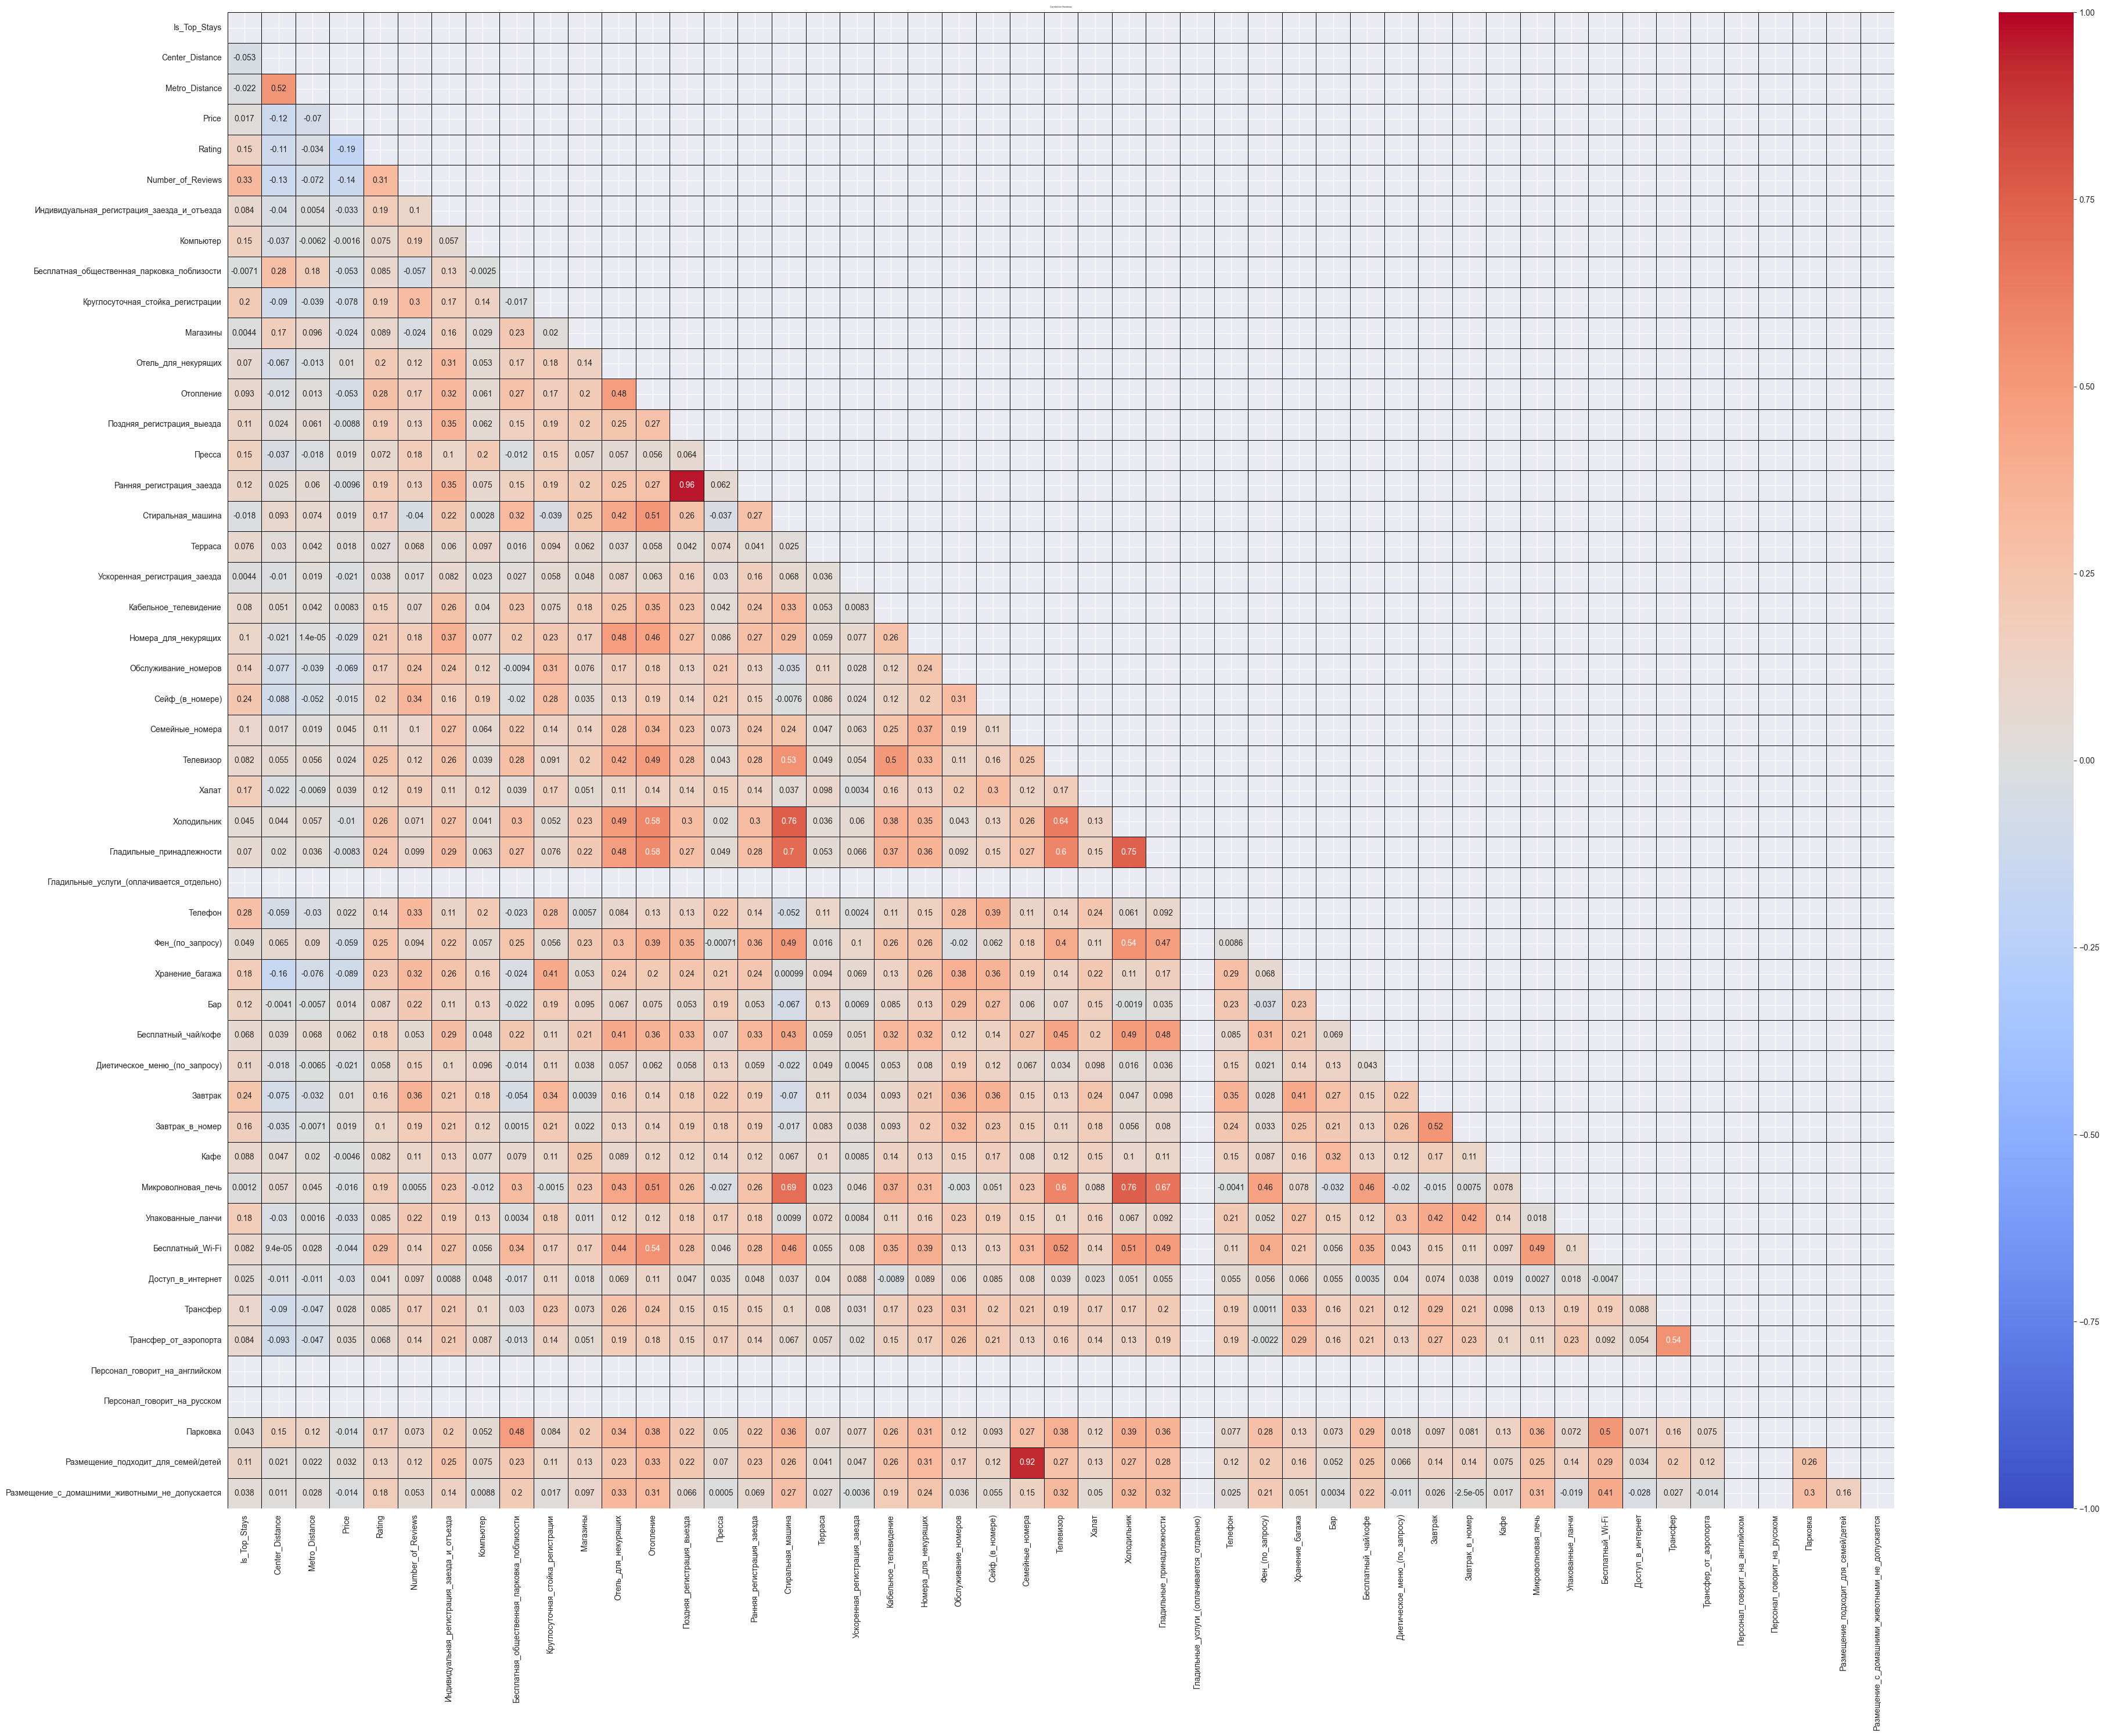

In [16]:
corr = df.drop(['Hotel_Name', 'Description'], axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(40, 30))
sns.heatmap(df.corr(), mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, linecolor='black')
plt.title('Correlation Heatmap', fontsize=3)
plt.tight_layout()
plt.show()

Из матрицы корреляций можем видеть, что хорошие для предсказания признаки - расстояние до метро, до центра города, рейтинг, количество отзывов. Остальные признаки являются по сути дополнительными услугами, которые предоставляет отель. Они влияют уже слабее, но можно выделить "размещение подходит для детей", "Доступ в интернет", "Бесплатный wifi", "Беслпатный чай/кофе" и другие признаки, покрывающие базовые потребности.

Проанализируем числовые признаки

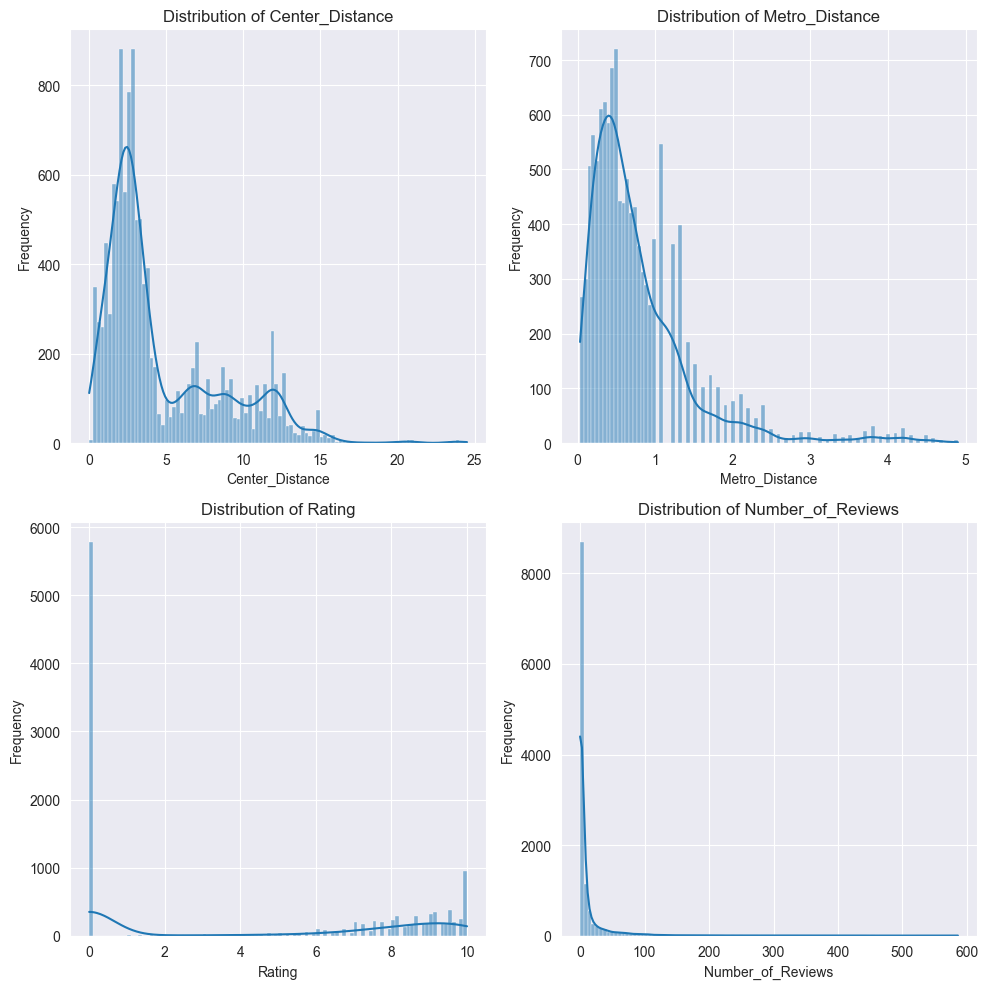

In [17]:
plt.figure(figsize=(10, 10))
num_features = ["Center_Distance", "Metro_Distance", "Rating", "Number_of_Reviews"]
for idx, feature in enumerate(num_features, 1):
    plt.subplot(2, 2, idx)
    sns.histplot(df[feature], kde=True, bins=100)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()



1. Можно видеть, что огромная часть отелей находится на расстоянии от 0 до 5 км от центра (с пиком для примерно 2,5 км), потом от 5 км относительно равномерно распределено количество отелей вплоть до 12,5 км, откуда уже идёт сильный спад по количеству отелей. Собственно, дальше 12,5 км даже можно уже считать как за Ленинградскую область. Можно попробовать создать признак, что отель загородный, но смысла в это нет, так как разделение на 12,5 км решающее дерево сможет сделать. Для линейных моделей смысл в этом есть.
2. Расстояние до метро имеет пик в 0,5 км, после чего количество отелей постепенно идёт на спад. Логично. Не особо выгодно строить отель там, где нет метро для приезжих. Довольно сильно коррелирует с расстоянием от центра, ведь в центре всё утыкано станциями.
3. Половина отелей не имеет рейтинга, поэтому значение стоит в нуле. Из-за этого не очень видно распределение остальной выборки. Рассмотрим подробнее чуть позже.
4. Большая часть отелей не имеют отзывов, особо сказать нечего.

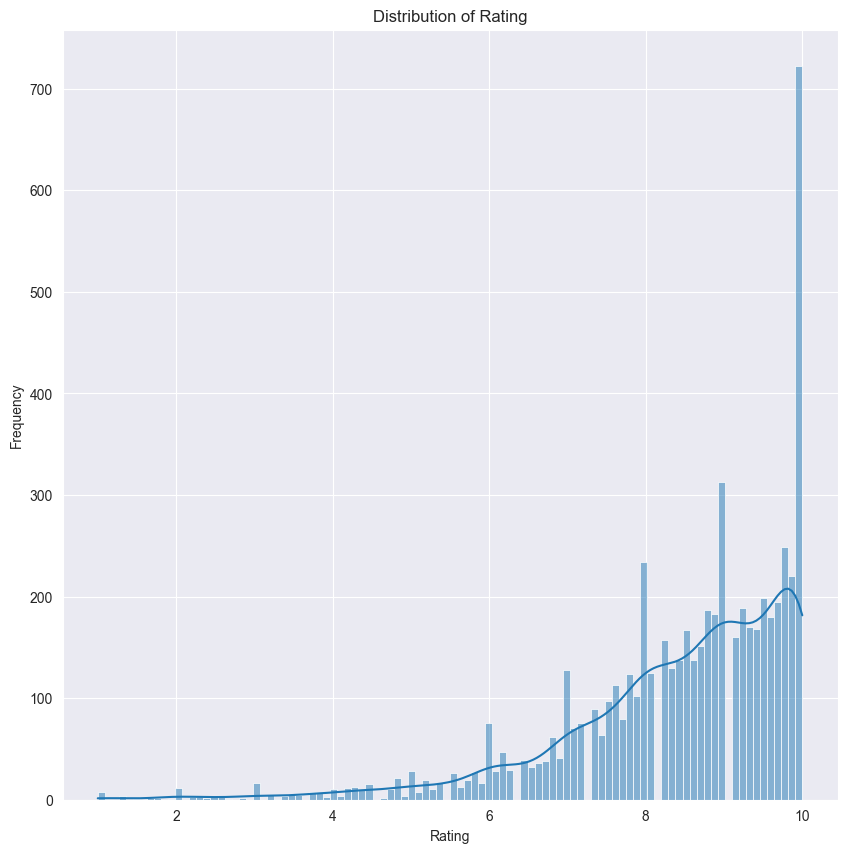

In [18]:
plt.figure(figsize=(10, 10))

sns.histplot(df['Rating'][df['Rating']>0], kde=True, bins=100)
plt.title(f"Distribution of Rating")
plt.xlabel('Rating')
plt.ylabel("Frequency")
plt.show()

Большая часть отелей имеет рейтинг от 8.5 до 10. Очень мало отелей с низким рейтингом. Может быть это связано с тем что такие долго не живут. Может быть потому что они исключаются из сервиса. Может быть потому что если отелю пофиг на рейтинг, но он и не пытается себя продвигать на сторонних сайтах.

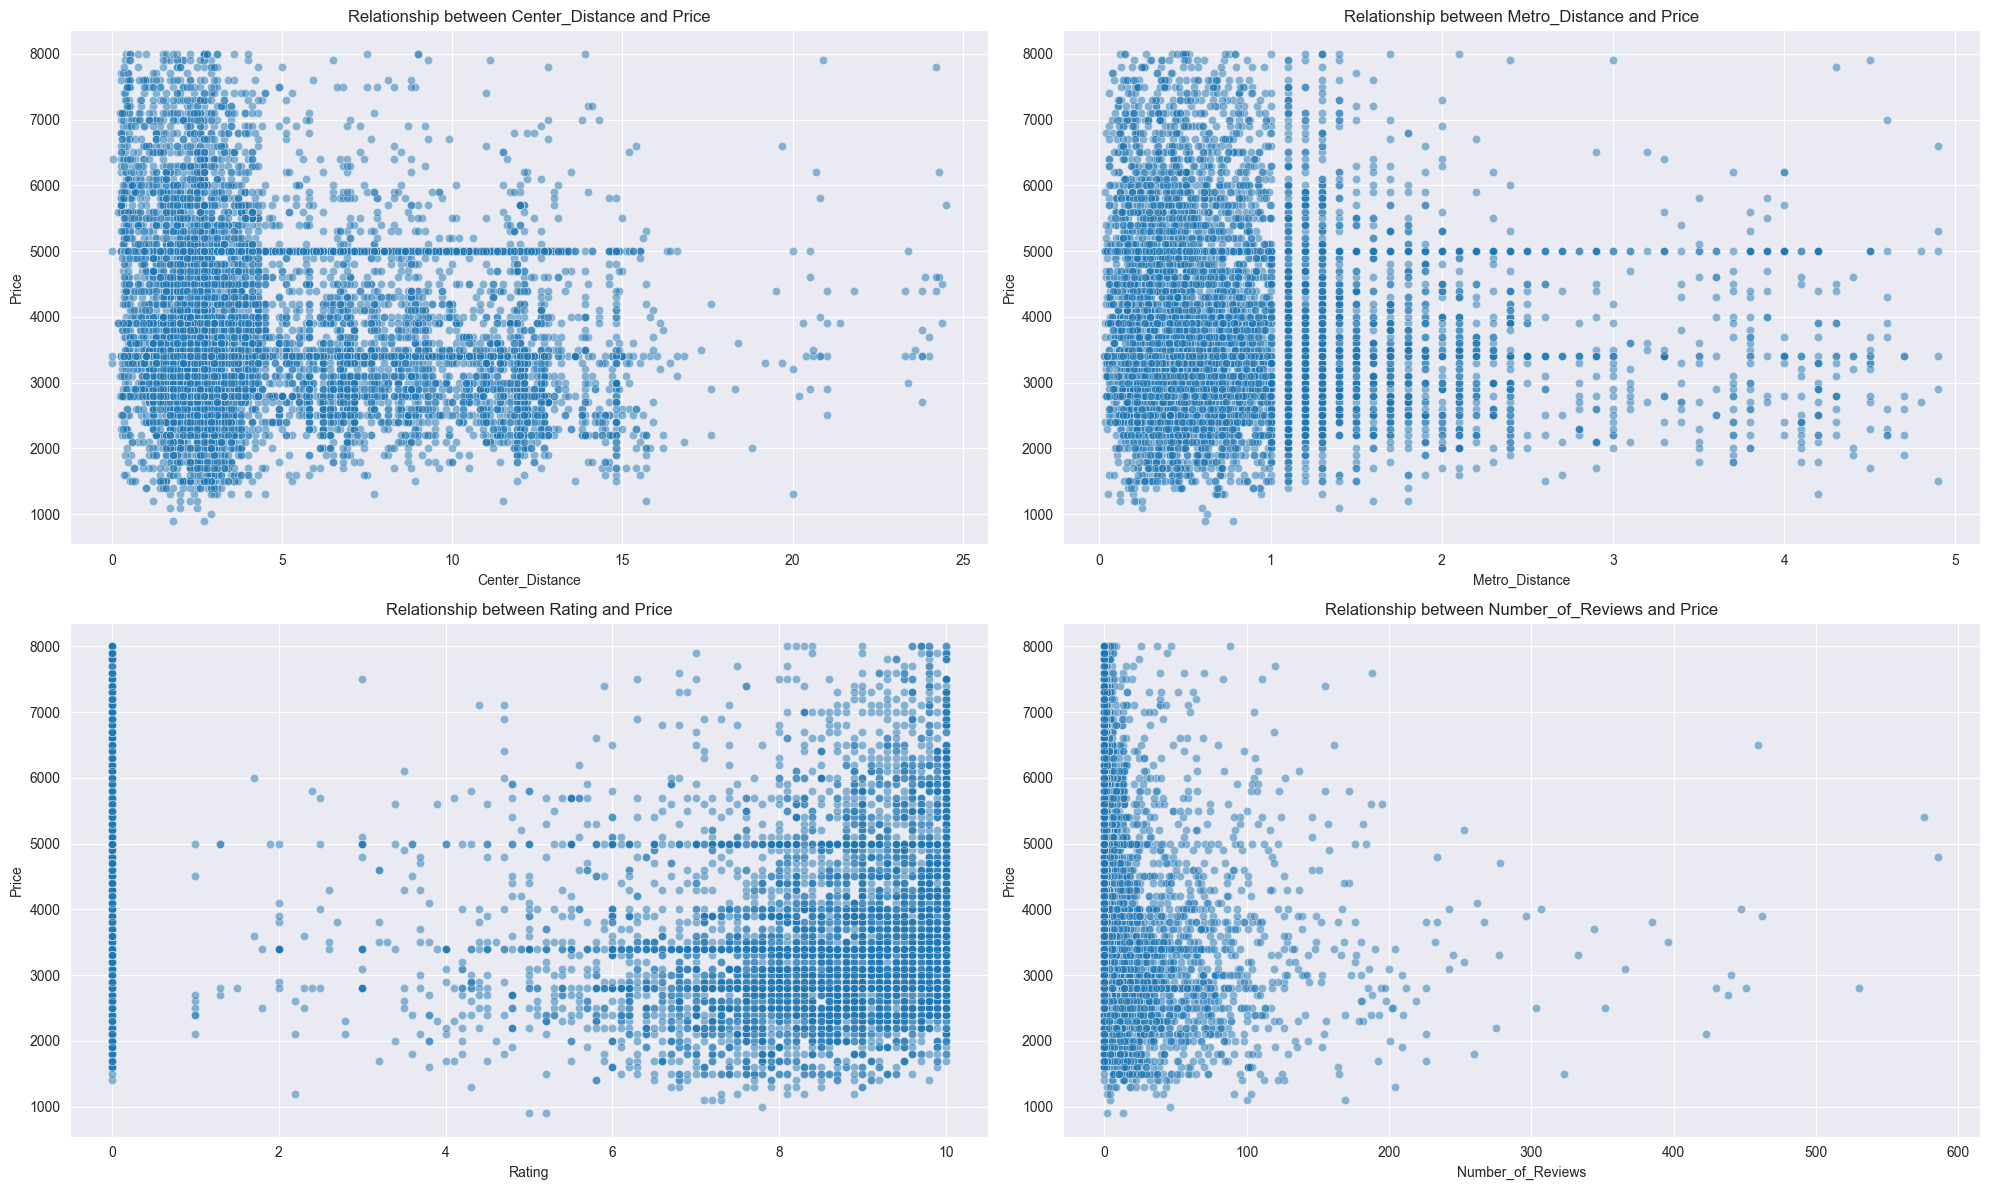

In [19]:
plt.figure(figsize=(20, 12))


for idx, feature in enumerate(num_features, 1):
    plt.subplot(2, 2, idx)
    sns.scatterplot(x=df[feature], y=df["Price"], alpha=0.5)
    plt.title(f"Relationship between {feature} and Price")
    plt.xlabel(feature)
    plt.ylabel("Price")

plt.tight_layout()
plt.show()

1. Цена кажется выше для отелей, расположенных ближе к центру. Это довольно ожидаемо.
2. Не то, чтобы было что-то интересное про расстояние до метро и ценой, однако есть некоторые отели, которые находятся далеко от метро, но при этом имеют высокую цену. Это может быть из-за других факторов, таких как роскошь или уникальные услуги.
3. Низкие оценки как правило получают отели с более низкой стоимостью.
4. Нет явной зависимости между количеством отзывов и ценой. При этом видно, что отели в ценовом диапазоне от 2000 до 5000 получают больше отзывов. Если предположить, что количество отзывов коррелирует с популярностью места, то, вероятно, отели в этом ценовом диапазоне самые популярные.

Создадим новый признак, что если расстояние до центра больше 12,5 км, то отель считается загородным.

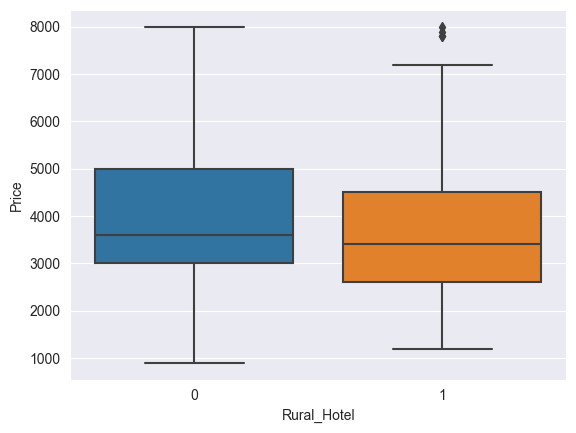

In [41]:
df['Rural_Hotel'] = df['Center_Distance'].apply(lambda x: 1 if x > 12.5 else 0)
sns.boxplot(data=df, y='Price', x='Rural_Hotel')
df.drop('Rural_Hotel', axis=1)
plt.show()


Есть видимая разница, загородные места дешевле. 

In [22]:
df['Hotel_Name']

0        Апартаменты Премиум на Стрелке Васильевского
1                               Апартаменты Антресоль
2        Апартаменты 15 комнат Петербургская квартира
4                              Отель ARTSTUDIO Nevsky
6                          Апартаменты Art Rubinstein
                             ...                     
12614                        Квартира в ЖК Пять звезд
12615               Мини-отель Хадсон на Гончарной 15
12616       Апартаменты Лофт в отеле на Ломоносовской
12617                            Travelto Liteiniy 58
12618                Apartment near Center Almazova 2
Name: Hotel_Name, Length: 11927, dtype: object

In [23]:
df['Description']

0        Выбор туристов, которые хотят везде чувствоват...
1        Подходящий вариант для большой компании: апарт...
2        Залог хорошего отдыха — чувствовать себя в нов...
4        Отель бизнес-класса «ARTSTUDIO Nevsky» располо...
6        Апартаменты Art Rubinstein располагаются в Сан...
                               ...                        
12614    Выбор туристов, которые хотят везде чувствоват...
12615    Почувствовать себя как дома во время долгой по...
12616    Подходящий вариант для большой компании: апарт...
12617    «Travelto Liteiniy 58» располагается в Санкт-П...
12618    В поисках домашнего уюта: апартаменты «Apartme...
Name: Description, Length: 11927, dtype: object

Немного изучив названия отелей и доменную область выясняется, что мини-отель, отель, апарт-отель, гостевой дом и т.д. являются разными заведениями для временного жилья. Соответственно имеет смысл выделять тип сдаваемого жилья как отдельную категорию.

In [24]:
categories = ["апартамент", 'апарт-отел', 'хостел', 'гостевой дом', 'мини-отель', 'гостиниц']

for category in categories:
    df[f"{category}"] = df.apply(lambda row: has_keyword(row, category), axis=1)




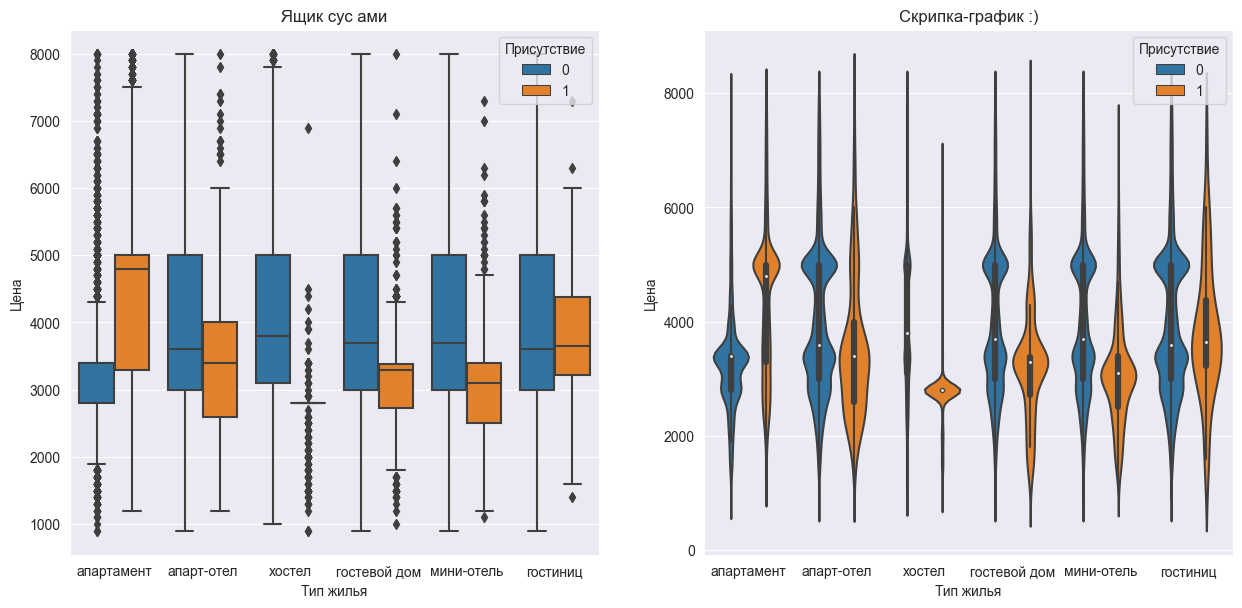

In [25]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
sns.boxplot(data=df.melt(id_vars='Price', value_vars=[category for category in categories],
                         var_name='Category', value_name='Presence'),
            x='Category', y='Price', hue='Presence')
plt.title('Ящик сус ами')
plt.ylabel('Цена')
plt.xlabel('Тип жилья')
plt.legend(title='Присутствие', loc='upper right')

plt.subplot(2, 2, 2)
sns.violinplot(data=df.melt(id_vars='Price', value_vars=[category for category in categories],
                            var_name='Category', value_name='Presence'),
               x='Category', y='Price', hue='Presence')
plt.title('Скрипка-график :)')
plt.ylabel('Цена')
plt.xlabel('Тип жилья')
plt.legend(title='Присутствие', loc='upper right')
plt.show()


Можно видеть значимые различия между разными категориями. Так например почти все хостелы стоят в районе 3к, а большая часть апартаментов находится в районе 4,5к.

In [26]:
tree = DecisionTreeRegressor()
X, y = df.drop(['Hotel_Name', 'Price', 'Description'], axis=1), df['Price']

metrics = get_model_metrics(X, y, tree, random_state=42)

Train:
MAE: 3.0277621620248176
MAPE: 0.0007549310734857253
MSE: 2663.7986615976347
Test:
MAE: 898.6074068429474
MAPE: 0.24648387717430092
MSE: 1809483.514371021


Если ещё подумать, то наверное стоит выделить отсутствие и малое кол-во отзывов (а, соответственно, нерелевантный рейтинг) как отдельную категорию. Исходя из изначальных перцентилей 

In [27]:
df[df['Number_of_Reviews'] != 0]['Number_of_Reviews'].describe()

count    5956.000000
mean       19.934016
std        39.926576
min         1.000000
25%         2.000000
50%         6.000000
75%        18.000000
max       586.000000
Name: Number_of_Reviews, dtype: float64

Думаю, что 25%, то есть 2 отзыва, это достаточно малое число отзывов, чтобы судить об отеле. Поэтому сделаем новую фичу - непопулярное место

<Axes: xlabel='Unpopular', ylabel='Price'>

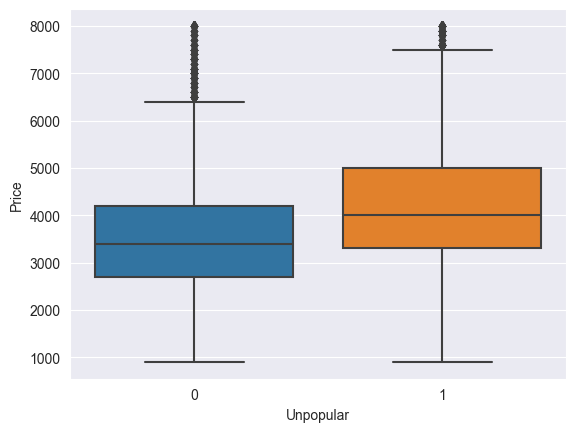

In [28]:
df['Unpopular'] = (df['Number_of_Reviews'] < 3).astype(int)
sns.boxplot(data=df, y='Price', x='Unpopular')


Довольно неожиданно, но оказывается отели (и не только) без отзывов более дорогие

In [29]:
df['Price'].name

'Price'

In [30]:
tree = DecisionTreeRegressor(max_depth=40, min_samples_split=20, min_impurity_decrease=1e-20)
X, y = df.drop(['Hotel_Name', 'Price', 'Description'], axis=1), df['Price']

metrics = get_model_metrics(X, y, tree, random_state=43)

Train:
MAE: 482.94333983002616
MAPE: 0.13252193211410038
MSE: 510375.472520991
Test:
MAE: 824.5697854669501
MAPE: 0.22474048447736655
MSE: 1416954.3138225821


Но будто бы сильно на качество это не повлияло. Оно, в принципе, и логично. Ведь деревья нелинейны, а значит для нуля отзывов дерево само подобрало необходимое значение.

Проанализируем числовые признаки

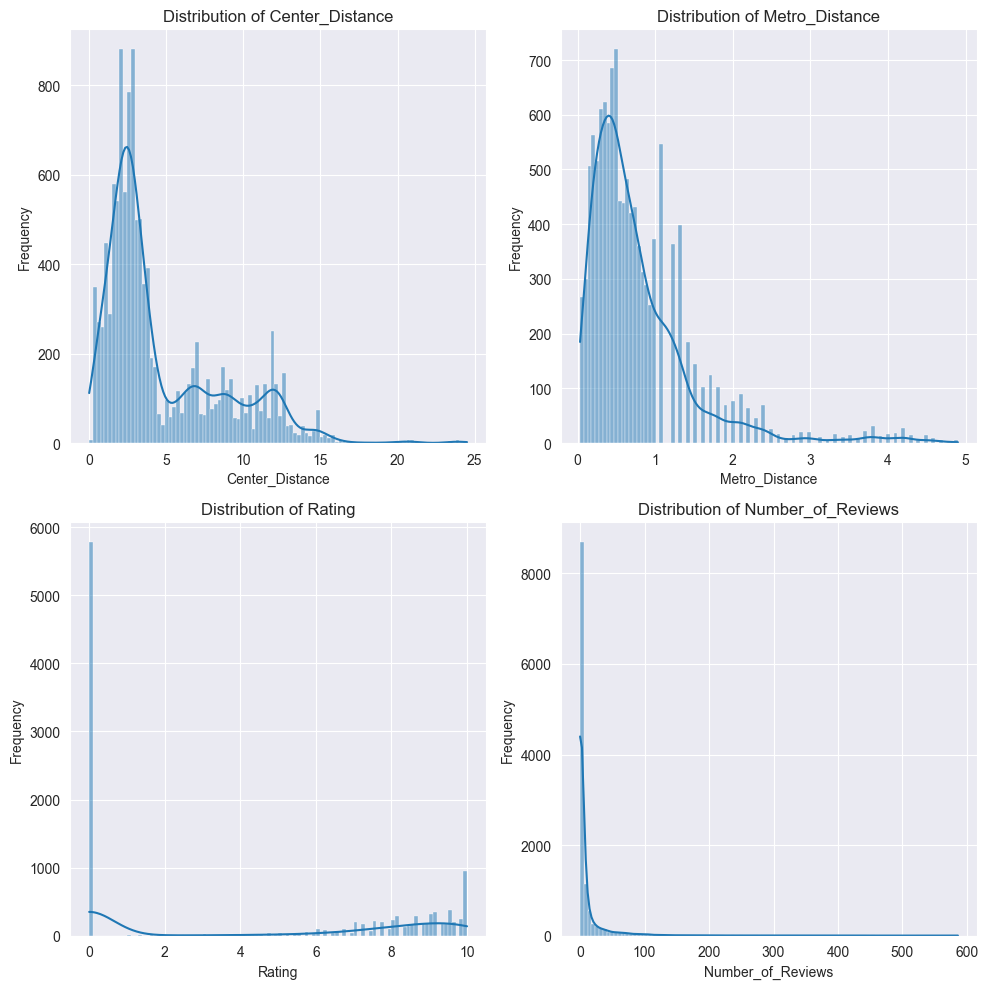

In [31]:
plt.figure(figsize=(10, 10))

for idx, feature in enumerate(["Center_Distance", "Metro_Distance", "Rating", "Number_of_Reviews"], 1):
    plt.subplot(2, 2, idx)
    sns.histplot(df[feature], kde=True, bins=100)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Реализовал DesicionTreeRegressor. Попробуем построить его и сравнить с библиотечной моделью

In [32]:
from decision_tree import MyDecisionTreeRegressor

my_tree = MyDecisionTreeRegressor(max_depth=4, min_samples_split=20, min_information_gain=1e-20)
X, y = df.drop(['Hotel_Name', 'Price', 'Description'], axis=1), df['Price']

my_tree_metrics = get_model_metrics(X, y, my_tree, random_state=43)

Train:
MAE: 728.7962997777946
MAPE: 0.20733195278098504
MSE: 1050477.3374479022
Test:
MAE: 746.9230828002372
MAPE: 0.20953422742416775
MSE: 1112804.7561476717


Посмотрим на визуализацию моего дерева (представление в виде вложенных словарей)

In [33]:
my_tree.tree

{'апартамент <= 0.5': [{'хостел <= 0.5': [{'Завтрак <= 0.5': [{'Фен_(по_запросу) <= 0.5': [3407.6399790685505,
        2938.5123966942147]},
      {'Сейф_(в_номере) <= 0.5': [3470.5179282868526, 4186.759581881533]}]},
    {'Фен_(по_запросу) <= 0.5': [{'Number_of_Reviews <= 45.5': [2806.5533980582522,
        2634.782608695652]},
      {'Rating <= 9.05': [2303.061224489796, 3175.0]}]}]},
  {'Center_Distance <= 4.85': [{'Number_of_Reviews <= 4.5': [{'Center_Distance <= 1.95': [5125.4857142857145,
        4700.8533333333335]},
      {'Rating <= 9.350000000000001': [3634.8936170212764,
        4530.981595092025]}]},
    {'Number_of_Reviews <= 0.5': [{'Фен_(по_запросу) <= 0.5': [4471.719457013574,
        3777.9591836734694]},
      {'Rating <= 9.75': [3327.140783744557, 3725.531914893617]}]}]}]}

Теперь посмотрим на визуализацию дерева библиотечного, которое было построенно в тех же условиях.

Train:
MAE: 728.7962997777946
MAPE: 0.20733195278098504
MSE: 1050477.3374479022
Test:
MAE: 746.9230828002372
MAPE: 0.20953422742416775
MSE: 1112804.7561476717


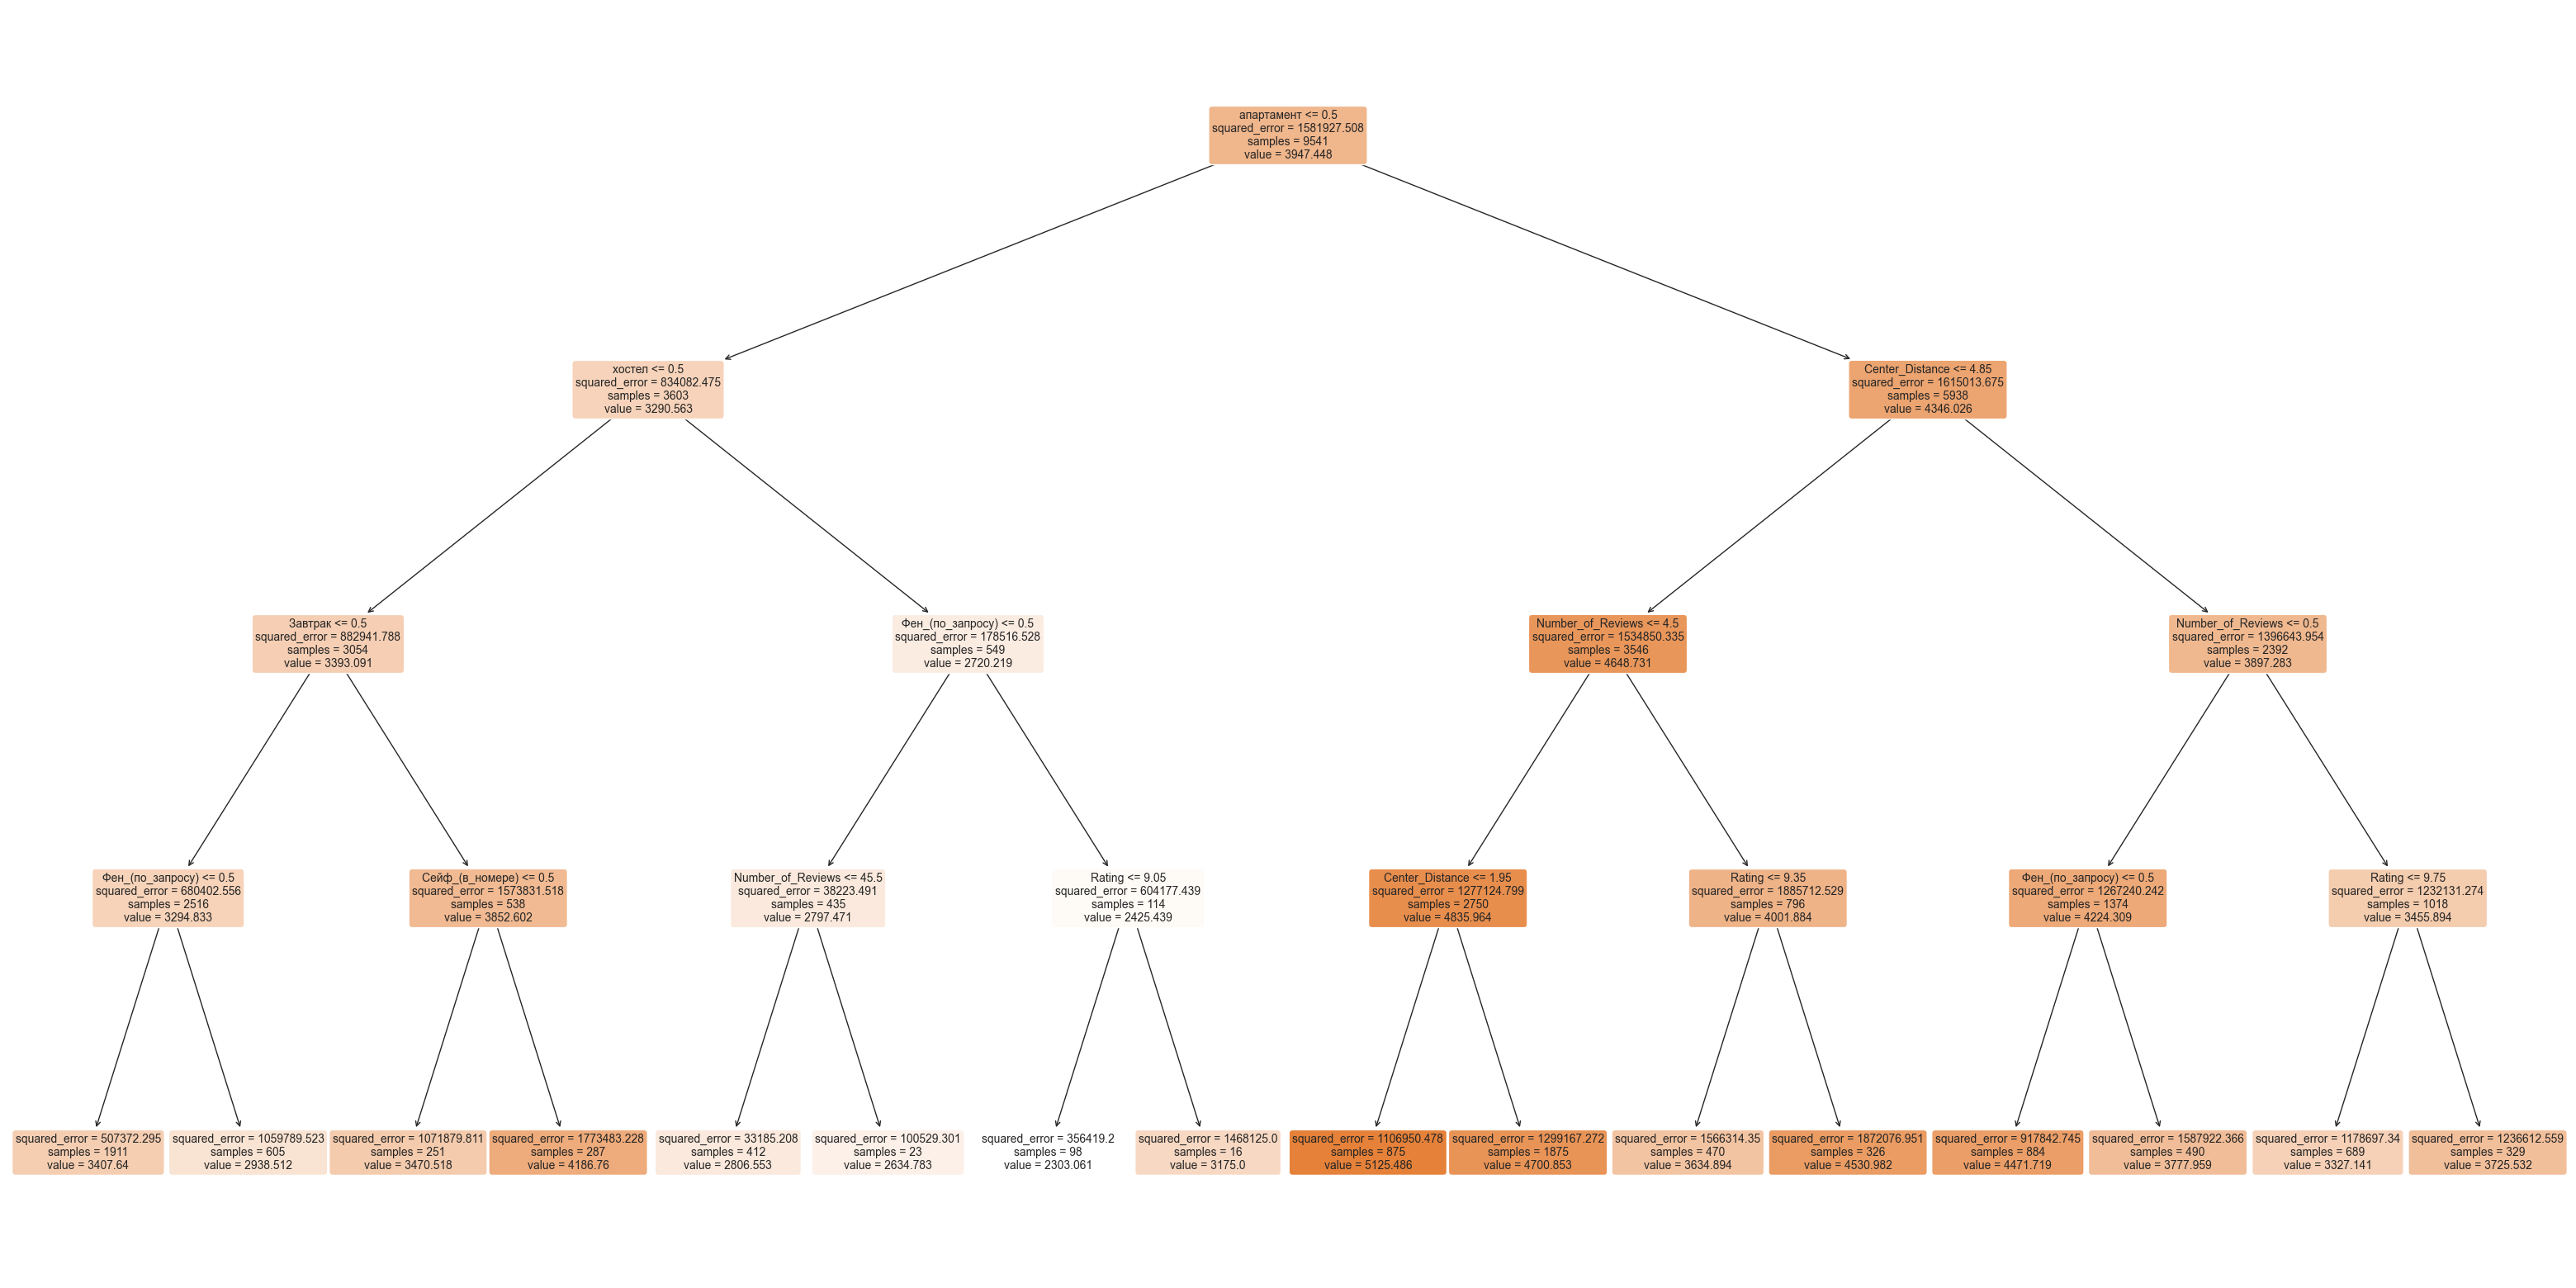

In [34]:
from sklearn.tree import plot_tree

plt.figure(figsize=(40, 20))
tree = DecisionTreeRegressor(max_depth=4, min_samples_split=20, min_impurity_decrease=1e-20)
X, y = df.drop(['Hotel_Name', 'Price', 'Description'], axis=1), df['Price']

get_model_metrics(X=X, y=y, model=tree)

plot_tree(tree, filled=True, feature_names=X.columns, rounded=True, fontsize=10)
plt.show()


Можно видеть, что структура библиотечной модели и моей очень даже похожи, что не может не радовать. Условия на решающих узлах одинаковые совпадают, насколько я могу это видеть. Например, если идти по левой ветке дерева, то сначала выбирается апартаменты->хостел->завтрак->фен. И там и там. 

Устроим подбор гиперпараметров

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=43)  # 0.25 * 0.8 = 0.2

param_dist = {
    'max_depth': [None] + list(np.arange(3, 20)),
    'min_samples_split': np.arange(2, 40),
    'min_impurity_decrease': loguniform(1e-10, 1e-2)
}

tree = DecisionTreeRegressor()
tree_search = RandomizedSearchCV(tree, param_distributions=param_dist, n_iter=100, cv=5, verbose=1, n_jobs=-1,
                                 random_state=43)
tree_search.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19],
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000192A6849120>,
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39])},
                   random_state=43, verbose=1)

In [36]:
best_tree = tree_search.best_estimator_
best_params = tree_search.best_params_
print("Best params:", best_params)


Best params: {'max_depth': 6, 'min_impurity_decrease': 5.067950230470428e-06, 'min_samples_split': 38}


In [37]:
sklearn_metrics = get_model_metrics(X, y, best_tree, random_state=43)

Train:
MAE: 679.3089510638323
MAPE: 0.1924117172255001
MSE: 955223.8652506807
Test:
MAE: 724.0118245028305
MAPE: 0.2020931109694888
MSE: 1078016.3754020676


In [38]:
my_tree = MyDecisionTreeRegressor(max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], min_information_gain=best_params['min_impurity_decrease'])

my_tree_metrics = get_model_metrics(X, y, my_tree, random_state=43)

Train:
MAE: 679.3089510638323
MAPE: 0.1924117172255001
MSE: 955223.8652506807
Test:
MAE: 724.0118245028305
MAPE: 0.2020931109694888
MSE: 1078016.3754020676


Мне кажется, вполне неплохо. Они вообще почти ничем не отличаются. Ни метриками, ни структурой (выводил выше). Но стоит признать, что моя реализация довольно медленная. По моим замерам библиотечный вариант обучается и предсказывает за 300 ms, в то время как моё дерево обучается и предсказывает за 2+ секунды.